<a href="https://colab.research.google.com/github/jonad/AnoGan-Pytorch/blob/master/notebooks/AnoGanCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from torch.autograd import Variable

In [0]:
manualseed = 999
random.seed(manualseed)

In [4]:
torch.manual_seed(manualseed)

In [0]:
normal_roots = '/content/drive/My Drive/data/normals/'
cancerous_roots = '/content/drive/My Drive/data/cancers/'

In [6]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
image_size = 64
nc = 3
batch_size = 64
workers = 4
n_channels = 3
n_latent_vector = 100
n_generator_feature_map = 64
n_discriminator_feature_map = 64
num_epochs = 5
learning_rate = 0.0002
beta1 = 0.5
ngpu = 1

In [0]:
normal_images = datasets.ImageFolder(root=normal_roots,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [0]:
cancerous_images = datasets.ImageFolder(root=cancerous_roots,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [0]:
dataloader_normal = torch.utils.data.DataLoader(normal_images, batch_size=1,
                                         shuffle=True, num_workers=workers)

In [0]:
dataloader_cancer = torch.utils.data.DataLoader(cancerous_images, batch_size=1,
                                         shuffle=True, num_workers=workers)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

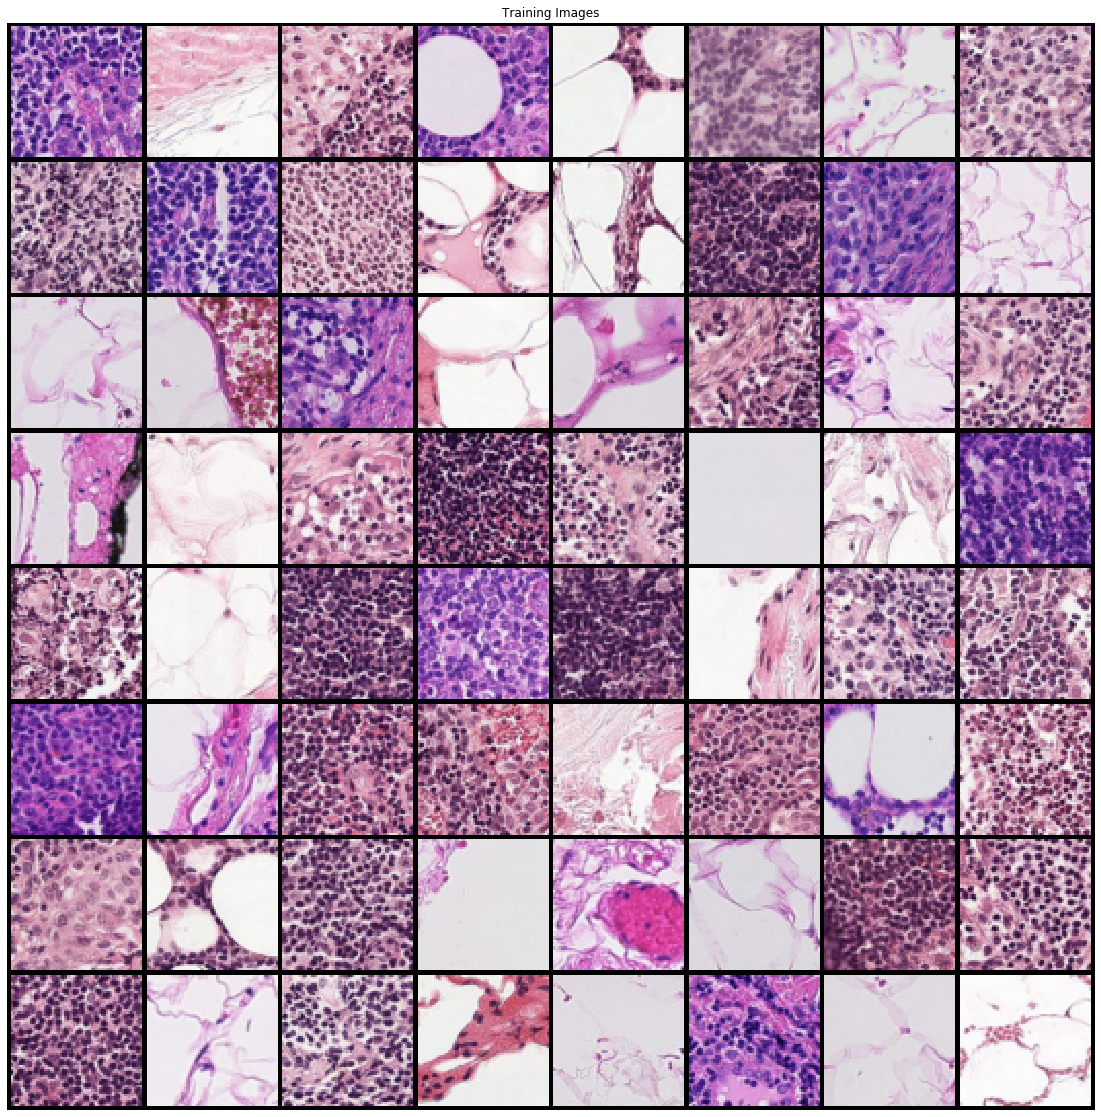

In [13]:
real_batch = next(iter(dataloader_normal))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

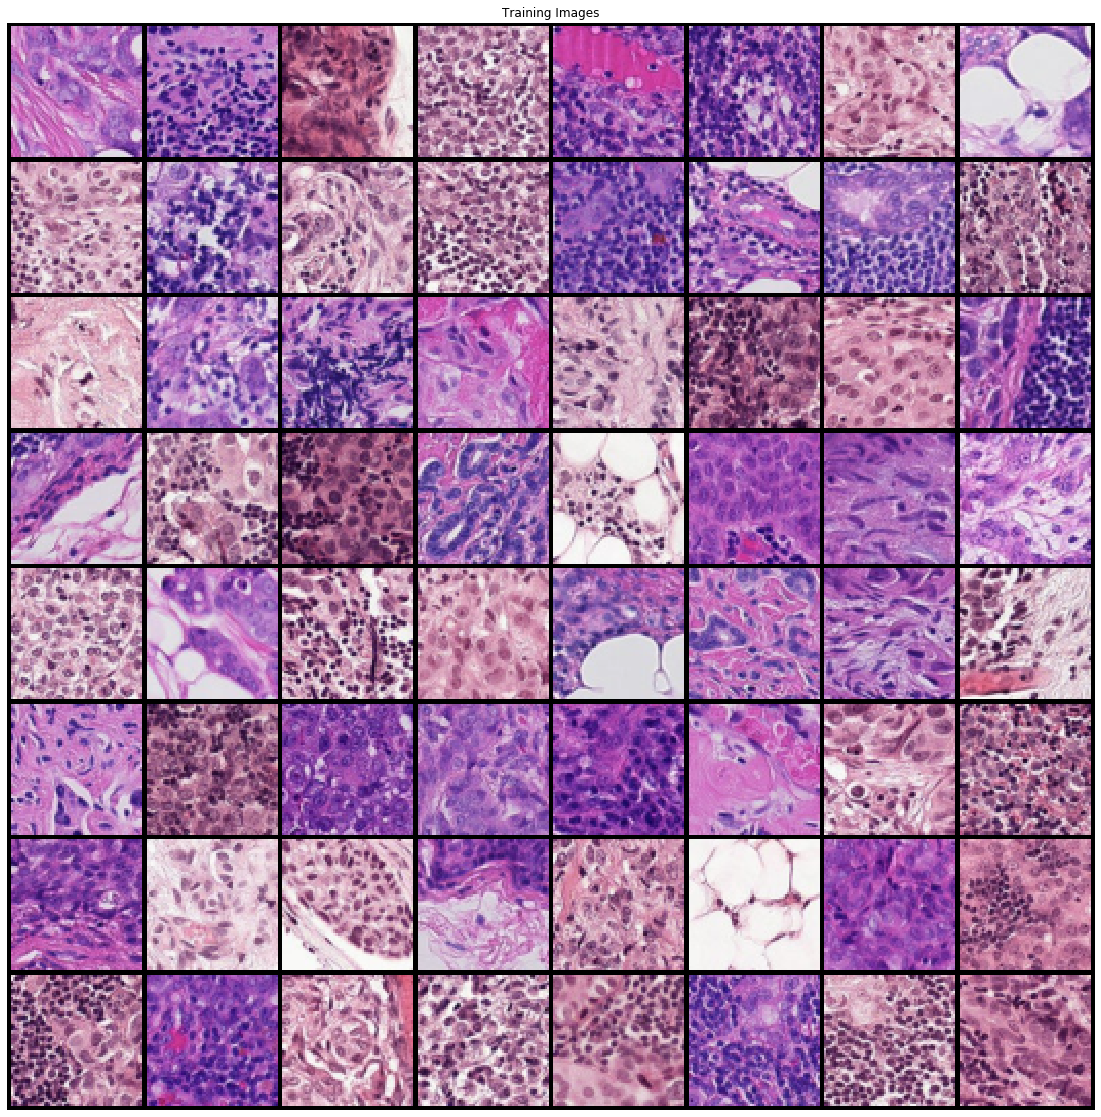

In [0]:
real_batch = next(iter(dataloader_cancer))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, init_zero_weights=False):
  '''Creates a convolutional layer, with optional batch normalization'''
  layers = []
  conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
  if init_zero_weights:
    conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, bias=False):
  """Creates a convolutional layer, with optimal batch normalization
  """
  layers = []
  layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias))
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

### Generator

In [0]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.convT1 = deconv(n_latent_vector, n_generator_feature_map*8, 4, 1, 0)
    self.convT2 = deconv(n_generator_feature_map*8,n_generator_feature_map*4, 4, 2, 1)
    self.convT3 = deconv(n_generator_feature_map*4, n_generator_feature_map*2, 4, 2, 1)
    self.convT4 = deconv(n_generator_feature_map*2, n_generator_feature_map, 4, 2, 1)
    self.output = deconv(n_generator_feature_map, n_channels, 4, 2, 1, batch_norm=False)

  def forward(self, input):
    out = F.relu(self.convT1(input), inplace=True)
    out = F.relu(self.convT2(out), inplace=True)
    out = F.relu(self.convT3(out), inplace=True)
    out = F.relu(self.convT4(out), inplace=True)
    return F.tanh(self.output(out))

In [0]:
netG = Generator(ngpu).to(device)

In [0]:
#handle multi-gpu of desired
if(device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

In [20]:
#apply the weights_init function
netG.apply(weights_init)
print(netG)

Generator(
  (convT1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


## Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu

    self.conv1 = conv(n_channels, n_discriminator_feature_map, 4, 2, 1)
    self.conv2 = conv(n_discriminator_feature_map, n_discriminator_feature_map*2, 4, 2, 1)
    self.conv3 = conv(n_discriminator_feature_map*2, n_discriminator_feature_map*4, 4, 2, 1)
    self.conv4 = conv(n_discriminator_feature_map*4, n_discriminator_feature_map*8, 4, 2, 1)
    self.output = conv(n_discriminator_feature_map*8, 1, 4, 1, 0, batch_norm=False)

  def forward(self, input):
    out = F.leaky_relu(self.conv1(input), inplace=True)
    out = F.leaky_relu(self.conv2(out), inplace=True)
    out = F.leaky_relu(self.conv3(out), inplace=True)
    out = F.leaky_relu(self.conv4(out), inplace=True)
    return F.sigmoid(self.output(out)), out.view(-1)

In [22]:
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


## Loss Functions and Optimizers

In [0]:
# Initialize BCELoss Function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, n_latent_vector, 1, 1, device=device)

real_label = 1
fake_label = 0

# setup adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))



In [0]:
checkpoint_dir = '/content/drive/My Drive/data/models/'

In [0]:
def create_dir(directory):
    """Creates a directory if it does not already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

create_dir(checkpoint_dir)
def checkpoint(G, D):
    """
    Saves the parameters of the generator G and discriminator D.
    """
    G_path = os.path.join(checkpoint_dir, 'G.pkl')
    D_path = os.path.join(checkpoint_dir, 'D.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def load_checkpoint(model, checkpoint_name):
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, checkpoint_name)))

## Training

In [26]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print(f'Starting Training Loop ... ')
for epoch in range(num_epochs):
  for i, data in enumerate(dataloader_normal,0):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    real_data = data[0].to(device)
    b_size = real_data.size(0)
    label = torch.full((b_size, ), real_label, device=device)
    # Forward pass
    output = netD(real_data)[0].view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    noise = torch.randn(b_size, n_latent_vector, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach())[0].view(-1)
    errD_fake = criterion(output, label)
    # calculate the gradients for the batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake)[0].view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()
    # Output training stats
    if i %10 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader_normal),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 10 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_normal)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
    iters += 1
        
        
    
      


Starting Training Loop ... 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/5][0/157]	Loss_D: 1.4523	Loss_G: 6.3845	D(x): 0.6741	D(G(z)): 0.5953 / 0.0020
[0/5][10/157]	Loss_D: 0.4473	Loss_G: 6.0980	D(x): 0.8266	D(G(z)): 0.1702 / 0.0028
[0/5][20/157]	Loss_D: 0.3518	Loss_G: 10.0478	D(x): 0.8864	D(G(z)): 0.1747 / 0.0001
[0/5][30/157]	Loss_D: 0.2005	Loss_G: 11.8444	D(x): 0.9611	D(G(z)): 0.1420 / 0.0000
[0/5][40/157]	Loss_D: 0.0866	Loss_G: 18.3007	D(x): 0.9389	D(G(z)): 0.0000 / 0.0000
[0/5][50/157]	Loss_D: 0.0060	Loss_G: 6.2672	D(x): 0.9973	D(G(z)): 0.0033 / 0.0031
[0/5][60/157]	Loss_D: 0.0257	Loss_G: 7.1646	D(x): 0.9792	D(G(z)): 0.0009 / 0.0011
[0/5][70/157]	Loss_D: 0.0415	Loss_G: 18.4808	D(x): 0.9619	D(G(z)): 0.0000 / 0.0000
[0/5][80/157]	Loss_D: 0.3118	Loss_G: 25.1451	D(x): 0.8181	D(G(z)): 0.0000 / 0.0000
[0/5][90/157]	Loss_D: 1.9774	Loss_G: 15.5514	D(x): 0.9737	D(G(z)): 0.7692 / 0.0000
[0/5][100/157]	Loss_D: 0.6062	Loss_G: 2.0762	D(x): 0.6805	D(G(z)): 0.1175 / 0.1590
[0/5][110/157]	Loss_D: 0.6925	Loss_G: 1.6563	D(x): 0.6524	D(G(z)): 0.1185 / 0.2596
[0/5][120

## Results

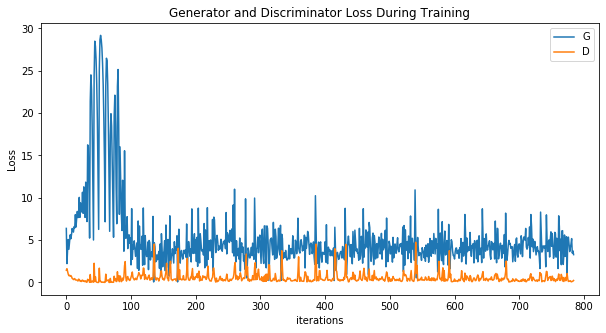

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Save Model

In [0]:
create_dir(checkpoint_dir)
checkpoint(netG, netD)

## Real Vs Fake

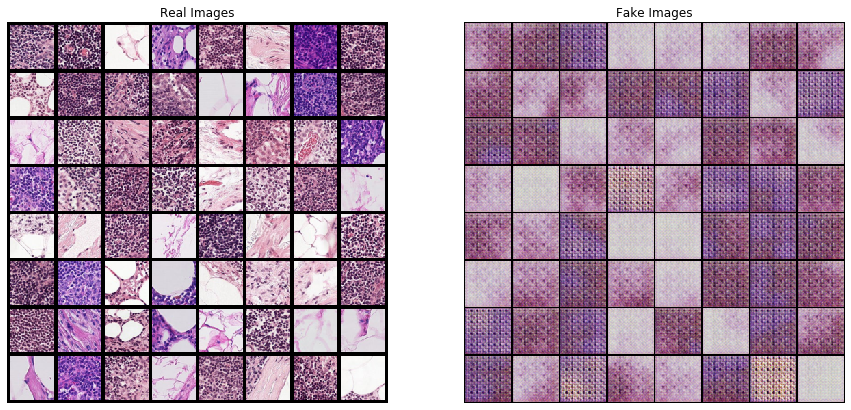

In [29]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader_normal))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Inverse Mapping

In [0]:
def freeze_network(network):
 for param in network.parameters():
  param.requires_grad = False

In [0]:
def inv_map(generator_model, discriminator_model, input_image, z_latent, n_backprop=5000, l=0.1):
  optimizerZ = optim.Adam([z_latent], lr=learning_rate, betas=(beta1, 0.999))
  input_image = input_image.to(device)
  for iters in range(1, n_backprop+1):

    z_latent = z_latent.to(device)
    generator_z = generator_model(z_latent)
    _, x_features = discriminator_model(input_image)
    _, generator_z_features = discriminator_model(generator_z)
    residual_loss = torch.sum(torch.abs(input_image - generator_z))
    discriminator_loss = torch.sum(torch.abs(x_features - generator_z_features))
    total_loss = (1 - l)*residual_loss + l*discriminator_loss
    if iters == n_backprop:
      print(f'Anomalies score = {total_loss}')
    total_loss.backward()
    optimizerZ.step()


In [0]:
cancer_img = next(iter(dataloader_cancer))[0]
real_img = next(iter(dataloader_normal))[0]
z_latent_real = torch.randn(1, 100, 1, 1, device=device, requires_grad=True)
z_latent_cancer = torch.randn(1, 100, 1, 1, device=device, requires_grad=True)

In [99]:
z_latent_cancer

tensor([[[[-1.6551]],

         [[-0.4037]],

         [[ 1.0175]],

         [[ 0.2160]],

         [[-0.1045]],

         [[-0.5474]],

         [[ 1.1611]],

         [[ 1.2169]],

         [[ 0.7498]],

         [[ 0.8522]],

         [[-0.7000]],

         [[ 0.5875]],

         [[ 0.2868]],

         [[ 1.1248]],

         [[-0.9415]],

         [[ 0.4470]],

         [[-0.3746]],

         [[-0.1167]],

         [[-1.1585]],

         [[-1.1637]],

         [[-0.4412]],

         [[ 0.2480]],

         [[ 0.8479]],

         [[-0.5682]],

         [[-0.0751]],

         [[-0.0269]],

         [[ 0.3543]],

         [[-0.7308]],

         [[-0.1074]],

         [[-0.7739]],

         [[-1.7583]],

         [[ 0.4704]],

         [[ 0.9696]],

         [[-0.2992]],

         [[-0.6914]],

         [[ 1.2159]],

         [[-0.8736]],

         [[-1.1611]],

         [[-2.0602]],

         [[-0.7452]],

         [[ 0.7092]],

         [[-0.2052]],

         [[-1.1020]],

         [[

In [100]:
z_latent_real

tensor([[[[-1.5716e-01]],

         [[-1.4985e+00]],

         [[-9.5121e-01]],

         [[ 5.1643e-02]],

         [[ 1.3596e+00]],

         [[-9.8533e-01]],

         [[ 2.7829e+00]],

         [[-1.3731e+00]],

         [[-4.8175e-01]],

         [[-1.3164e+00]],

         [[-3.5529e-02]],

         [[ 8.6330e-01]],

         [[ 1.7315e+00]],

         [[ 1.4274e-01]],

         [[-7.3528e-02]],

         [[ 6.8071e-01]],

         [[-2.0023e+00]],

         [[-1.0846e+00]],

         [[ 7.5928e-01]],

         [[ 4.4174e-01]],

         [[ 2.0953e-01]],

         [[-7.9212e-02]],

         [[ 1.0474e+00]],

         [[-4.3795e-02]],

         [[ 1.4502e+00]],

         [[-1.3759e-01]],

         [[-6.8927e-01]],

         [[-6.5625e-01]],

         [[ 5.4694e-01]],

         [[ 5.6850e-01]],

         [[ 8.2812e-01]],

         [[ 3.2887e-01]],

         [[ 1.4463e+00]],

         [[-8.7885e-01]],

         [[ 1.8716e+00]],

         [[ 1.6186e+00]],

         [[ 8.1346e-01]],

 

In [0]:
freeze_network(netG)
freeze_network(netD)
 

In [102]:
inv_map(netG, netD, cancer_img, z_latent_cancer, n_backprop=5000, l=0.1)
inv_map(netG, netD, real_img, z_latent_real, n_backprop=5000, l=0.1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss = 3309.09912109375
loss = 4084.74365234375


In [90]:
z_latent_cancer

tensor([[[[-0.9259]],

         [[-1.0805]],

         [[-1.8031]],

         [[-0.7228]],

         [[-0.7900]],

         [[-0.0236]],

         [[ 0.3850]],

         [[ 2.0242]],

         [[-0.2660]],

         [[-2.7333]],

         [[ 1.6537]],

         [[ 1.4514]],

         [[ 2.0250]],

         [[ 1.2744]],

         [[ 2.0293]],

         [[ 1.6191]],

         [[ 0.8842]],

         [[-0.5751]],

         [[ 0.1616]],

         [[ 1.5189]],

         [[-1.1497]],

         [[ 0.6299]],

         [[ 2.7197]],

         [[ 0.2497]],

         [[-1.0511]],

         [[-0.7871]],

         [[-1.0884]],

         [[ 2.1367]],

         [[ 0.5733]],

         [[-1.3692]],

         [[ 0.4546]],

         [[ 0.0322]],

         [[-0.6110]],

         [[ 0.7763]],

         [[ 1.0723]],

         [[ 0.8099]],

         [[ 0.1107]],

         [[ 0.3676]],

         [[ 1.2043]],

         [[ 1.1844]],

         [[-0.5609]],

         [[ 1.0974]],

         [[-1.0182]],

         [[